<a href="https://colab.research.google.com/github/edson-depaula/DIO_BairesDev_Bootcamp/blob/main/Detec%C3%A7%C3%A3o_com_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Montar o Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# 2. Clonar repositório do YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [3]:
import os
import shutil

# train_images_folder = "/content/gdrive/MyDrive/darknet/my_dataset/train/images"
# train_labels_folder = "/content/gdrive/MyDrive/darknet/my_dataset/train/labels"

# # Criar a pasta images caso não exista (normalmente já existe)
# os.makedirs(train_images_folder, exist_ok=True)

# # Listar todos os arquivos .txt da pasta de labels
# label_files = [f for f in os.listdir(train_labels_folder) if f.endswith(".txt")]

# for label_file in label_files:
#     src = os.path.join(train_labels_folder, label_file)
#     dst = os.path.join(train_images_folder, label_file)
#     shutil.move(src, dst)  # Move o arquivo


In [4]:
val_images_folder = "/content/gdrive/MyDrive/darknet/my_dataset/valid/images"
val_labels_folder = "/content/gdrive/MyDrive/darknet/my_dataset/valid/images"

os.makedirs(val_images_folder, exist_ok=True)

label_files = [f for f in os.listdir(val_labels_folder) if f.endswith(".txt")]

for label_file in label_files:
    src = os.path.join(val_labels_folder, label_file)
    dst = os.path.join(val_images_folder, label_file)
    shutil.move(src, dst)


In [5]:
# 3. Criar arquivo de configuração data.yaml
# Substitua os caminhos conforme sua estrutura
dataset_yaml = """
train: /content/gdrive/MyDrive/darknet/my_dataset/train
val: /content/gdrive/MyDrive/darknet/my_dataset/valid

nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
"""

with open("data.yaml", "w") as f:
    f.write(dataset_yaml)

In [14]:
# import os
# import glob

# train_images_path = "/content/gdrive/MyDrive/darknet/my_dataset/train/images/"
# valid_images_path = "/content/gdrive/MyDrive/darknet/my_dataset/valid/images/"

# for path in [train_images_path, valid_images_path]:
#     files = glob.glob(os.path.join(path, "*.txt"))
#     for f in files:
#         os.remove(f)
#     print(f"Removidos {len(files)} arquivos .txt em {path}")


Removidos 448 arquivos .txt em /content/gdrive/MyDrive/darknet/my_dataset/train/images/
Removidos 127 arquivos .txt em /content/gdrive/MyDrive/darknet/my_dataset/valid/images/


In [10]:
# 4. Treinar o modelo do zero (YOLOv5s é rápido para teste)
!python train.py --weights yolov5s.pt --data data.yaml --epochs 150 --batch-size 32 --img 640 --patience 50 --save-period 10

A saída de streaming foi truncada nas últimas 5000 linhas.
 19          [-1, 14]  1         0  models.common.Concat                    [1]                           
 20                -1  1    296448  models.common.C3                        [256, 256, 1, False]          
 21                -1  1    590336  models.common.Conv                      [256, 256, 3, 2]              
 22          [-1, 10]  1         0  models.common.Concat                    [1]                           
 23                -1  1   1182720  models.common.C3                        [512, 512, 1, False]          
 24      [17, 20, 23]  1     32364  models.yolo.Detect                      [7, [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]], [128, 256, 512]]
Model summary: 214 layers, 7038508 parameters, 7038508 gradients, 16.0 GFLOPs

Transferred 343/349 items from yolov5s.pt
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated.

In [11]:
# Bloco 1: Gerar matriz de confusão (vai avaliar o modelo no dataset de validação)
!python val.py --weights runs/train/from_scratch2/weights/best.pt --data data.yaml --img 640 --task val --conf 0.001 --save-conf --verbose


val: data=data.yaml, weights=['runs/train/from_scratch2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-423-g567c6646 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Traceback (most recent call last):
  File "/content/yolov5/val.py", line 604, in <module>
    main(opt)
  File "/content/yolov5/val.py", line 575, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/content/yolov5/val.py", line 270, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

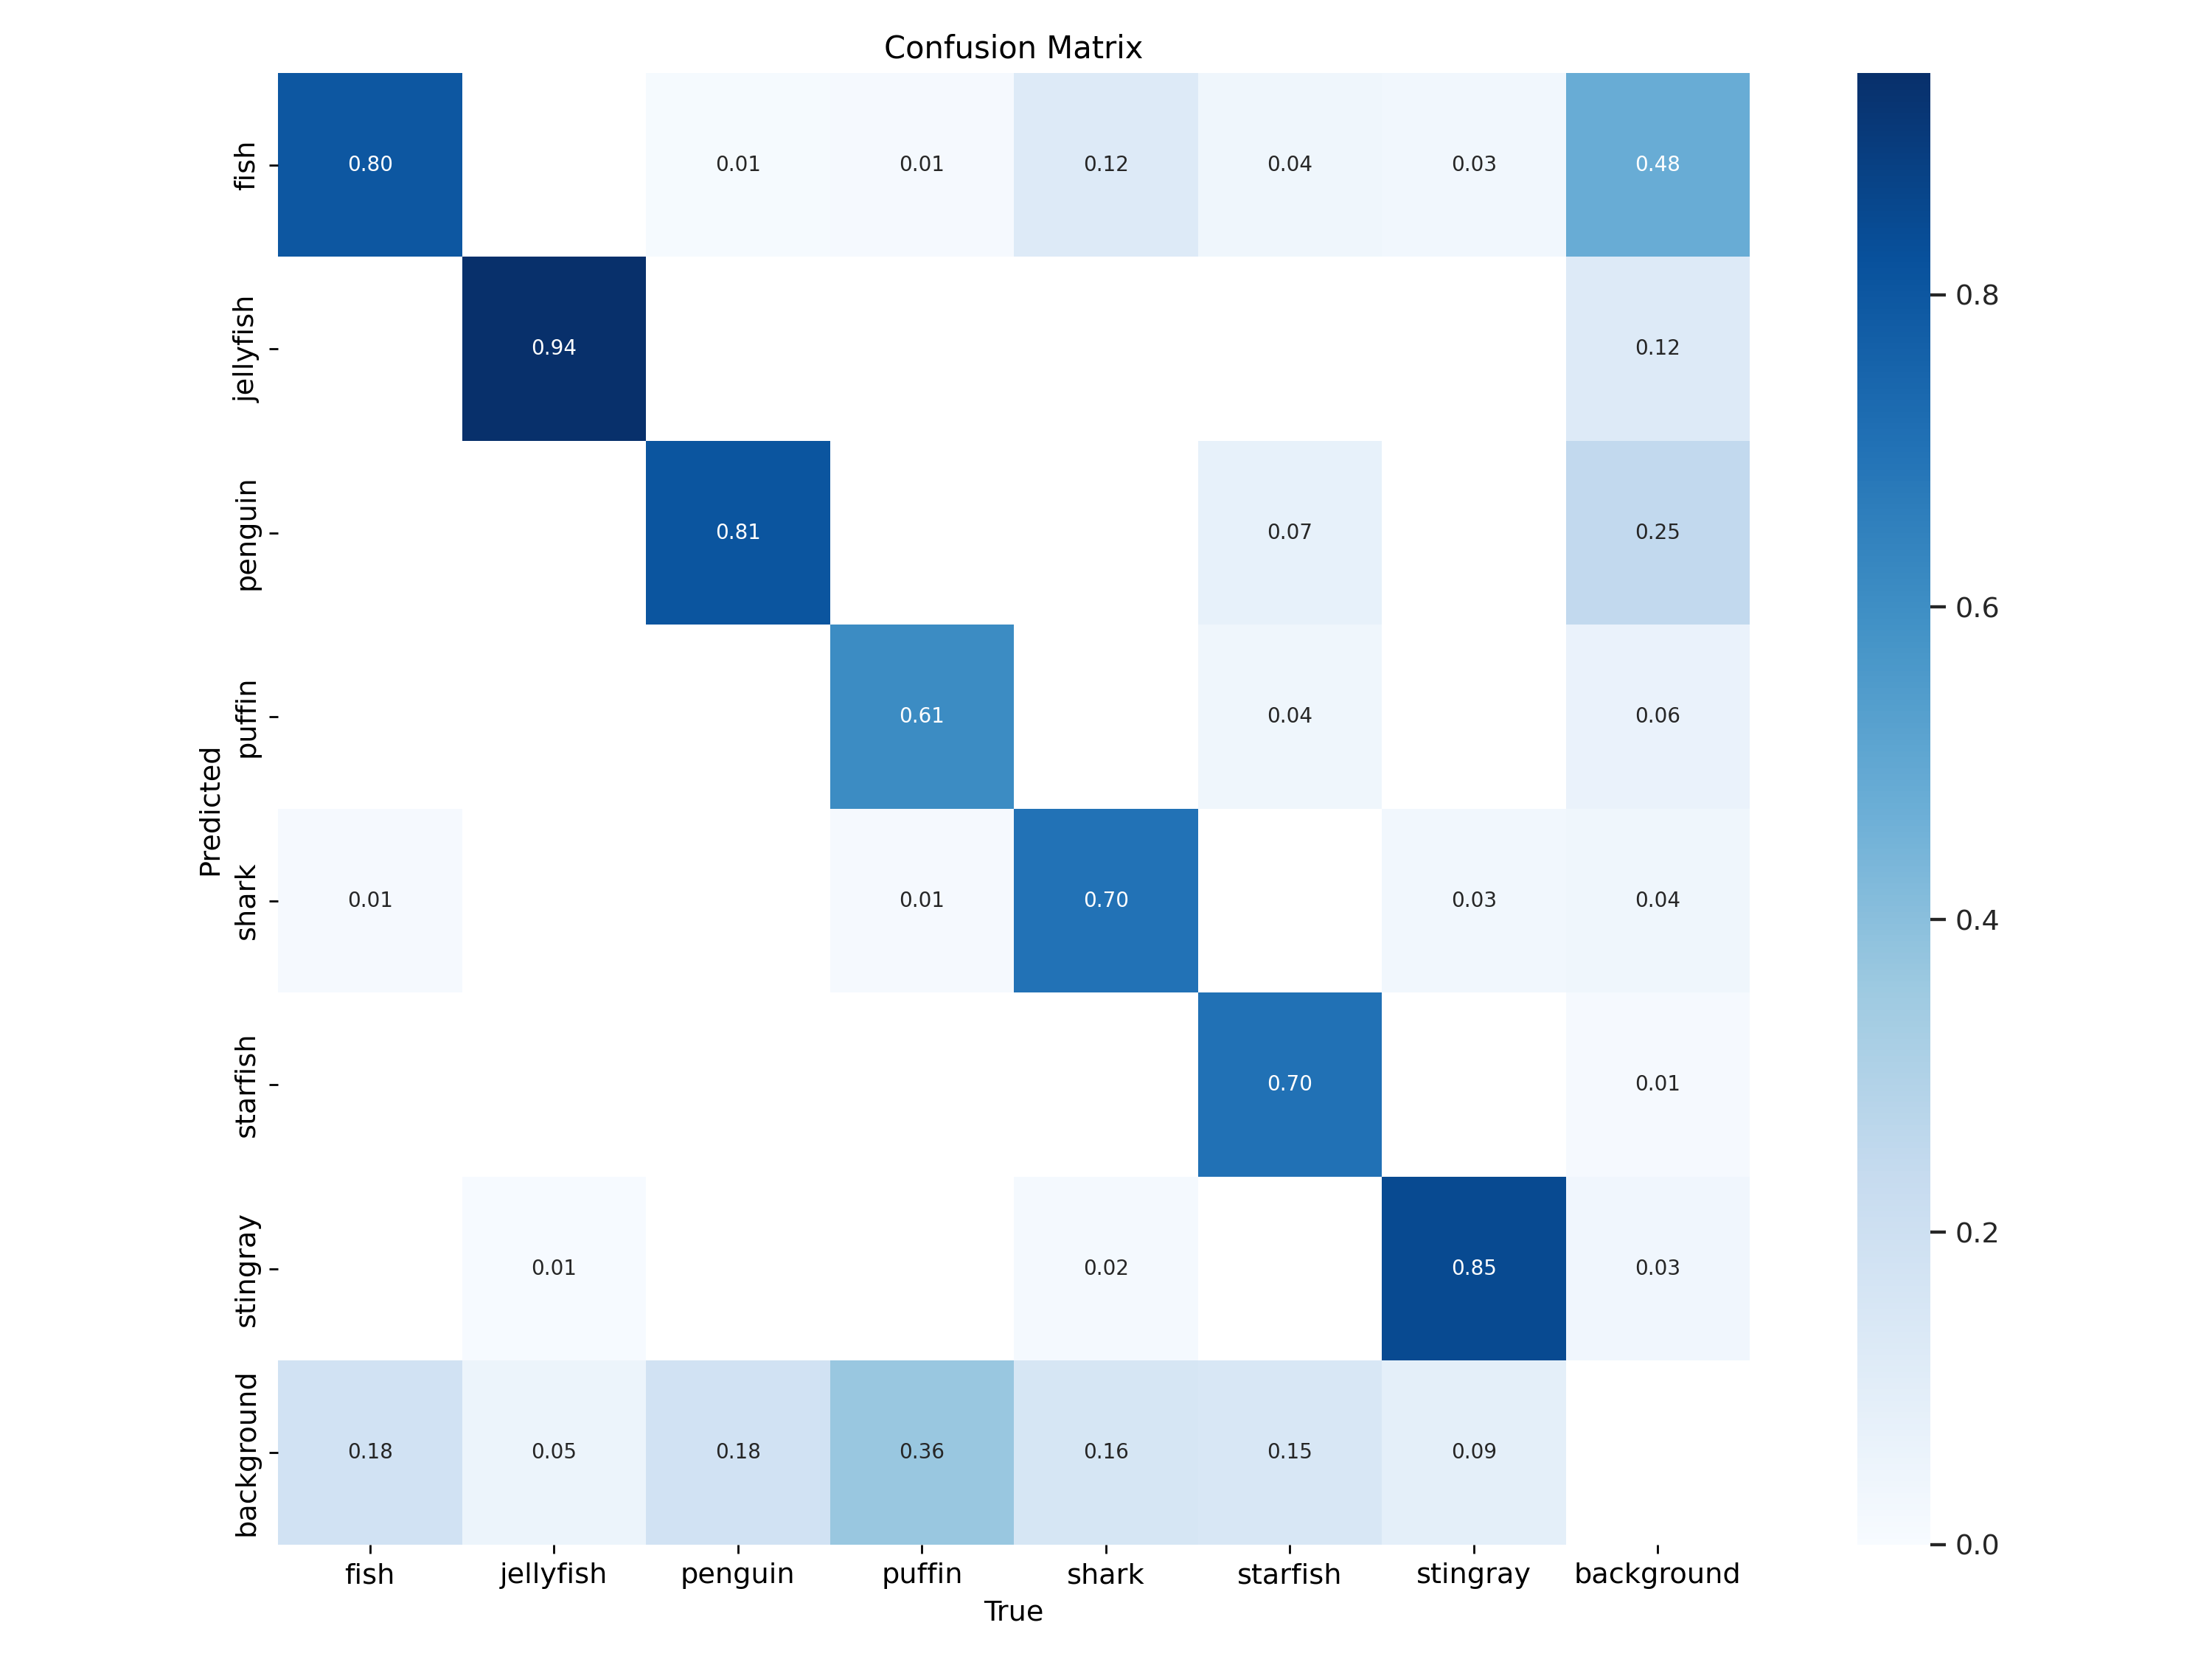

In [12]:
from IPython.display import Image, display

# Path to the confusion matrix image
confusion_matrix_path = 'runs/train/exp/confusion_matrix.png'

# Display the image
try:
    display(Image(filename=confusion_matrix_path))
except FileNotFoundError:
    print(f"Error: Confusion matrix image not found at {confusion_matrix_path}")

In [29]:
import torch
from matplotlib import pyplot as plt
import cv2
import numpy as np

# Carregar modelo treinado
model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp/weights/best.pt')
model.conf = 0.7  # confiança mínima
model.iou = 0.45  # limiar IoU padrão

# Caminho da imagem
img_path = '/content/will-drzycimski-ccJwEyfSZfY-unsplash-scaled.jpg.jpg'

# Ler a imagem e converter para RGB
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Imagem não encontrada: {img_path}")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Inferência
results = model(img_rgb)

# Imprimir resultados no terminal
results.print()

# Renderizar resultados (com caixas)
rendered_img = results.render()[0]  # retorna BGR

# Converter BGR para RGB para mostrar no matplotlib
rendered_img_rgb = cv2.cvtColor(rendered_img, cv2.COLOR_BGR2RGB)

# Exibir imagem
plt.figure(figsize=(12, 8))
plt.imshow(rendered_img_rgb)
plt.axis('off')
plt.title("Detecção YOLOv5")
plt.show()


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-8-10 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 2013x2560 1 jellyfish
Speed: 2.9ms pre-process, 7.2ms inference, 3.4ms NMS per image at shape (1, 3, 512, 640)


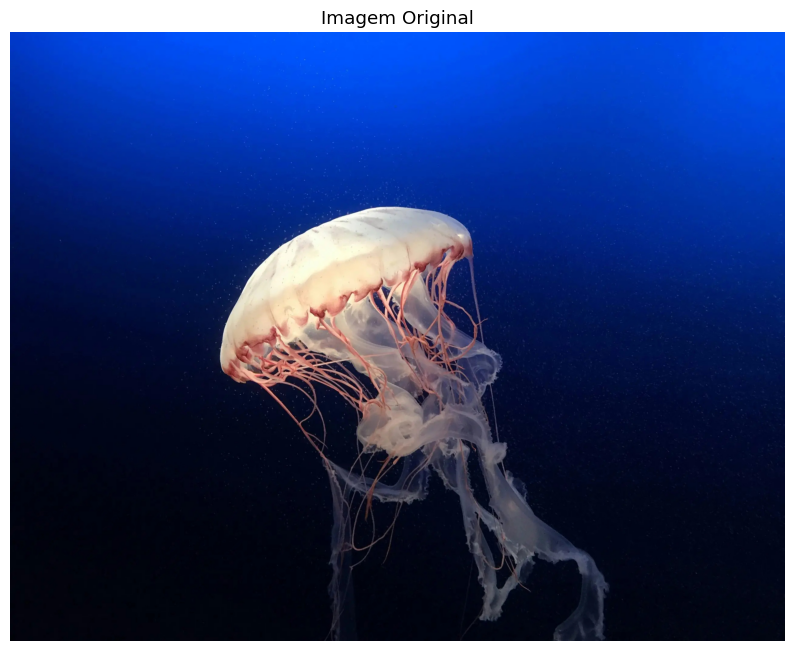

In [36]:
import matplotlib.pyplot as plt
import cv2

# Caminho da imagem
img_path = '/content/will-drzycimski-ccJwEyfSZfY-unsplash-scaled.jpg.jpg'

# Carregar imagem com OpenCV (BGR)
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Imagem não encontrada: {img_path}")

# Converter para RGB para exibir corretamente no matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar imagem original
plt.figure(figsize=(10,8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Imagem Original')
plt.show()


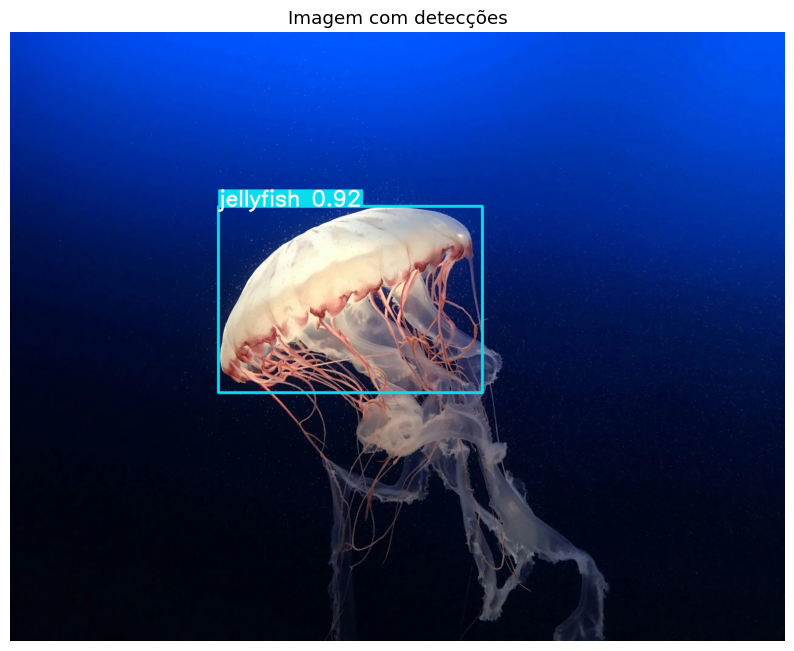

In [35]:
import matplotlib.pyplot as plt

# Renderiza a imagem com detecções (é uma lista, pega o primeiro elemento)
img_detected = results.render()[0]

plt.figure(figsize=(10, 8))
plt.imshow(img_detected)
plt.axis('off')
plt.title("Imagem com detecções")
plt.show()